In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dropout , Flatten , Dense ,BatchNormalization,Input,ReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping
from tensorflow.keras import models , optimizers , regularizers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image

## Obtain the information

In [3]:
# Train dataframe
df_train = pd.read_csv('/kaggle/input/ai-vs-human-generated-dataset/train.csv')

In [4]:
#Test dataframe
df_test = pd.read_csv('/kaggle/input/ai-vs-human-generated-dataset/test.csv')

# Clean data

In [5]:
# delete Unnamed column
df_train.drop(columns=['Unnamed: 0'],inplace=True)

In [11]:
#check if there are empty rows
df_train.isna().sum()

file_name    0
label        0
dtype: int64

In [5]:
#check if thera are duplicated rows
df_train.duplicated().sum()

0

In [ ]:
#label 1 -> AI Image
#label 0 -> Human Image
df_train['label'][0]

In [7]:
df_train.dtypes

file_name    object
label         int64
dtype: object

## Separete data

In [18]:
# Crear la carpeta si no existe
os.makedirs(location_AI, exist_ok=True)
os.makedirs(location_Hum, exist_ok=True)

In [19]:
# Separete de images depends of the label

for index , row in df_train.iterrows():
    if row['label'] == 1:
        origin_path = '/kaggle/input/ai-vs-human-generated-dataset/'+ row['file_name']
        dest_path = os.path.join(location_AI,os.path.basename(origin_path))

        # move the to the new carpet
        shutil.copy(origin_path,dest_path)

    else:
        origin_path = '/kaggle/input/ai-vs-human-generated-dataset/' + row['file_name']
        dest_path = os.path.join(location_Hum,os.path.basename(origin_path))

        # move the to the new carpet
        shutil.copy(origin_path,dest_path)
        


        

In [6]:
# Change the format in the rows

df_train['Images'] = df_train['file_name'].apply(lambda x:x.split('/')[1])


In [8]:
df_train.drop(columns = ['file_name'],inplace = True)

In [9]:
df_train.head()

,label,Images
0,1,a6dcb93f596a43249135678dfcfc17ea.jpg
1,0,041be3153810433ab146bc97d5af505c.jpg
2,1,615df26ce9494e5db2f70e57ce7a3a4f.jpg
3,0,8542fe161d9147be8e835e50c0de39cd.jpg
4,1,5d81fa12bc3b4cea8c94a6700a477cf2.jpg


## Get data and data Argumentation

In [10]:
# data Argumentation

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split = 0.3
    )

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_dir = '/kaggle/input/ai-vs-human-generated-dataset/train_data'

In [76]:
#Reset train data generator
train_generator.reset()

In [12]:
df_train['label'] = df_train['label'].astype('string')

In [13]:
df_train.dtypes

label     string[python]
Images            object
dtype: object

In [14]:
df_train['Images'][0]

'a6dcb93f596a43249135678dfcfc17ea.jpg'

In [77]:
# Get data of a DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe = df_train,
    directory = train_dir,
    x_col = "Images",
    y_col = "label",
    target_size = (28,28),
    batch_size = 64,
    class_mode = "binary",
    color_mode='grayscale',
    subset = "training",
    shuffle=True  # Baraja los datos para evitar quedarse sin imágenes
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe = df_train,
    directory = train_dir,
    x_col = "Images",
    y_col = "label",
    target_size = (28,28),
    batch_size = 64,
    class_mode = "binary",
    color_mode='grayscale',
    subset = "validation",
    shuffle=True  # Baraja los datos para evitar quedarse sin imágenes
)

Found 55965 validated image filenames belonging to 2 classes.
Found 23985 validated image filenames belonging to 2 classes.


In [16]:
train_generator[0][0].shape

(64, 28, 28, 1)

# Divide validation_generetaor data 

- 15 % -> validation
- 15 % -> test

In [51]:
len(validation_generator)

375

In [17]:
# Extract de batches in x_val y y_val from validation_generator
x_val = []
y_val = []
num_batches = len(validation_generator)
for i in range(num_batches):
    batch = validation_generator[i]
    images, labels = batch
    x_val.append(images)
    y_val.append(labels)

x_val = np.concatenate(x_val, axis=0)
y_val = np.concatenate(y_val, axis=0)




In [18]:
print(f"X_train shape: {len(x_val)}")
print(f"y_train shape: {len(y_val)}")

X_train shape: 23985
y_train shape: 23985


In [19]:
# Take 50 % of x_val and  y_val to x_test and y_test

x_test = x_val[:11992]
y_test = y_val[:11992]

x_val = x_val[11992:]
y_val = y_val[11992:]

In [78]:
print(f"x_test shape: {len(x_test)}")
print(f"y_test shape: {len(y_test)}")
print(f"x_val shape: {len(x_val)}")
print(f"y_val shape: {len(y_val)}")

x_test shape: 11992
y_test shape: 11992
x_val shape: 11993
y_val shape: 11993


##  Create Model

In [21]:
def model1 ():

    model = models.Sequential([
    Input(shape=(28, 28, 1)),
    Conv2D(32,(2,2),padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D((2,2)),

   
    Conv2D(64,(2,2),padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    
    Conv2D(128,(2,2),padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D((2,2)),
    Dropout(0.4),

   
    Conv2D(256,(2,2),padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D((2,2)),
    Dropout(0.5),


        


    Flatten(),

    Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.4),

    Dense(256,activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.6),
    Dense(1, activation='sigmoid')
    
    ])

    return model

## Callback definition

In [22]:
checkpoint = ModelCheckpoint('best_wights.keras',monitor='val_accuracy', verbose= 1, save_best_only=True)

## Compilation

In [23]:
model_1 = model1()

In [24]:
model_1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# Training

In [79]:
len(train_generator) 

875

In [81]:
hist = model_1.fit(train_generator,
                  
                  epochs=30,
                  validation_data=(x_val,y_val),
                  
                  callbacks=[checkpoint])

Epoch 1/30
868/875 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.8716 - loss: 0.3283
Epoch 1: val_accuracy did not improve from 0.87451
875/875 ━━━━━━━━━━━━━━━━━━━━ 184s 209ms/step - accuracy: 0.8716 - loss: 0.3283 - val_accuracy: 0.8351 - val_loss: 0.3913
Epoch 2/30
868/875 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.8733 - loss: 0.3267
Epoch 2: val_accuracy did not improve from 0.87451
875/875 ━━━━━━━━━━━━━━━━━━━━ 190s 215ms/step - accuracy: 0.8733 - loss: 0.3267 - val_accuracy: 0.6668 - val_loss: 1.7851
Epoch 3/30
868/875 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - accuracy: 0.8745 - loss: 0.3218
Epoch 3: val_accuracy improved from 0.87451 to 0.88502, saving model to best_wights.keras
875/875 ━━━━━━━━━━━━━━━━━━━━ 189s 214ms/step - accuracy: 0.8745 - loss: 0.3217 - val_accuracy: 0.8850 - val_loss: 0.2996
Epoch 4/30
868/875 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - accuracy: 0.8781 - loss: 0.3166
Epoch 4: val_accuracy did not improve from 0.88502
875/875 ━━━━━━━━━━━━━━━━━━━━ 189s 214ms/st

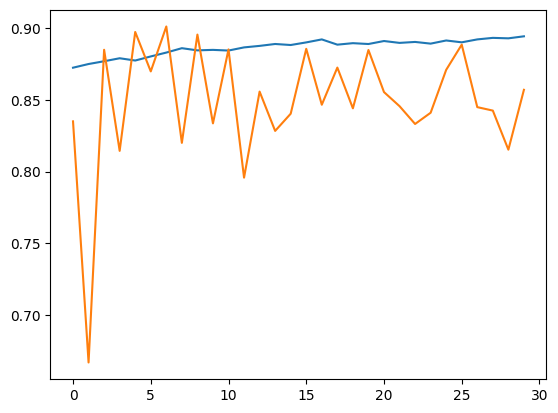

In [82]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.show()

# Creating Hypermodel

### Take the best weights to ather model

In [83]:
model_best = model_1

In [84]:
model_best.load_weights('best_wights.keras')

In [85]:
model_best.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [86]:
model_best.evaluate(x_test,y_test)

375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9022 - loss: 0.2600


[0.2666330933570862, 0.8969312906265259]

# Prediction

In [87]:
y_pred = model_best.predict(x_test)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [88]:
y_pred = y_pred.flatten()

In [89]:
y_pred = np.where(y_pred>0.5,1,0)

In [109]:
y_pred

array([1, 0, 0, ..., 0, 1, 1])

# Get F1 Score

In [91]:
from sklearn.metrics import f1_score

In [92]:
# Calcular F1-score
f1 = f1_score(y_test, y_pred)

print(f"F1-score: {f1:.2f}")

F1-score: 0.89


# Get test data

In [93]:
df_test.rename(columns={'id':'images'},inplace=True)

In [94]:
df_test['id'] = df_test.index

In [95]:
df_test

,images,Images,id
0,0,1a2d9fd3e21b4266aea1f66b30aed157.jpg,0
1,1,ab5df8f441fe4fbf9dc9c6baae699dc7.jpg,1
2,2,eb364dd2dfe34feda0e52466b7ce7956.jpg,2
3,3,f76c2580e9644d85a741a42c6f6b39c0.jpg,3
4,4,a16495c578b7494683805484ca27cf9f.jpg,4
...,...,...,...
5535,5535,483412064ff74d9d9472d606b65976d9.jpg,5535
5536,5536,c0b49ba4081a4197b422dac7c15aea7f.jpg,5536
5537,5537,01454aaedec140c0a3ca1f48028c41cf.jpg,5537
5538,5538,e9adfea8b67e4791968c4c2bdd8ec343.jpg,5538


In [40]:
x_test.shape

(11992, 28, 28, 1)

# Load test images

In [43]:
# Change the format in the rows

df_test['Images'] = df_test['images'].apply(lambda x:x.split('/')[1])

In [45]:
df_test.drop(columns=['images'],inplace=True)

In [96]:
test_dir = '/kaggle/input/ai-vs-human-generated-dataset/test_data_v2'

In [97]:
import cv2
import os
import numpy as np

# Ruta de la carpeta con imágenes
test_dir ="/kaggle/input/ai-vs-human-generated-dataset/test_data_v2"

# Obtener lista de archivos
imagenes = []
for archivo in os.listdir(test_dir):
    if archivo.endswith('.jpg') or archivo.endswith('.png'):  
        img = cv2.imread(os.path.join(test_dir, archivo))  
        #img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (28, 28))  
        
        img = img / 255.0  
        imagenes.append(img)

imagenes = np.array(imagenes)  
print("Forma del array de imágenes:", imagenes.shape)


Forma del array de imágenes: (5540, 28, 28, 3)


# Prediction on the test data

In [ ]:
y_predict_test = model_best.predict(imagenes_gray)


In [ ]:
y_predict_test = np.where(y_predict_test>0.5,1,0)
df_final = pd.DataFrame()
df_final['id'] = df_test['id']
df_final['label'] = y_predict_test


In [ ]:

output = pd.DataFrame({'id': df_final.id, 'label': df_final.label})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")